In [2]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.compute as pc
import h5py
from src.generators import *
import time
from matplotlib import pyplot as plt
np.random.seed(0)

In [43]:
N = [10,100,200,300,500]
#N = [10]

In [4]:
generator = F2()
for item in N:
    generator.create_dataset(item,f"f2_{item}")

In [4]:
def is_leaf(name, node):
    """Check if a node is a dataset (leaf)."""
    return isinstance(node, h5py.Dataset)

def find_leaf_datasets(hdf5_file):
    """Find and return paths to all leaf datasets in an HDF5 file."""
    leaf_datasets = []

    # Traverse the HDF5 file
    hdf5_file.visititems(lambda name, node: leaf_datasets.append(name) if is_leaf(name, node) else None)
    
    return leaf_datasets

def string_with_most_char(strings, char):
    # Initialize variables to track the string with the most occurrences
    max_count = 0
    result_string = ""

    # Iterate through the list of strings
    for s in strings:
        # Count occurrences of the specified character in the current string
        count = s.count(char)
        
        # Update if the current string has more occurrences
        if count > max_count:
            max_count = count
            result_string = s

    return result_string

In [20]:
from tqdm import tqdm
t_load_h5 = []
t_manipulate_h5 = []
iterations = 100
selected_label = 6

for item in N:
    tmp_load = []
    tmp_manipulate = []
    for j in tqdm(range(iterations)):
        ### LOADING ###
        st_time = time.time()
        with h5py.File(f'f2_{item}.h5', 'r', driver="core") as f:
            en_time = time.time()
            ### ------ ###
            tmp_load.append(en_time - st_time)
            path = string_with_most_char(find_leaf_datasets(f),"/")
            start_time = time.time()
            ### MANIPULATION ###
            def get_all_image_datasets():
                image_datasets = []                
                def visit_func(name, obj):
                    #label_path = 'image/class_feature/class_image/label'            ## Indice di immagine deve variare nel framework
                    label_path = 'class_feature/class_image/label'                   ## Indice di immagine deve variare nel framework
                    if isinstance(obj, h5py.Dataset) and name.endswith(label_path) and obj[()] == selected_label :
                        #image_path = name.replace(label_path,'image/image')
                        image_path = name.replace(label_path,'image')
                        im_obj = f[image_path][:]
                        new_obj = np.transpose(im_obj)   
                        new_obj = np.square(new_obj)
                        new_obj = np.exp(new_obj)
                        new_obj = np.transpose(new_obj)
                        image_datasets.append(new_obj)
                f.visititems(visit_func)
                return image_datasets
            image_ds = get_all_image_datasets()
            ### ----------- ###
            end_time = time.time()
            tmp_manipulate.append(end_time-start_time)
    t_load_h5.append(sum(tmp_load) / len(tmp_load))
    t_manipulate_h5.append(sum(tmp_manipulate) / len(tmp_manipulate))

np.save("t_load_h5_f2",t_load_h5)
np.save("t_manipulate_h5_f2",t_manipulate_h5)


100%|██████████| 100/100 [01:20<00:00,  1.25it/s]


In [5]:
with h5py.File(f'f2_10.h5', 'r', driver="core") as f:
    leafs = find_leaf_datasets(f)
    print(leafs)

['example_0/image_feature/image/boundingbox_feature/bb1/bbox', 'example_0/image_feature/image/boundingbox_feature/bb1/text_feature/description', 'example_0/image_feature/image/boundingbox_feature/bb2/bbox', 'example_0/image_feature/image/boundingbox_feature/bb2/class_feature/label', 'example_0/image_feature/image/class_feature/class_image/label', 'example_0/image_feature/image/image', 'example_1/image_feature/image/boundingbox_feature/bb1/bbox', 'example_1/image_feature/image/boundingbox_feature/bb1/text_feature/description', 'example_1/image_feature/image/boundingbox_feature/bb2/bbox', 'example_1/image_feature/image/boundingbox_feature/bb2/class_feature/label', 'example_1/image_feature/image/class_feature/class_image/label', 'example_1/image_feature/image/image', 'example_2/image_feature/image/boundingbox_feature/bb1/bbox', 'example_2/image_feature/image/boundingbox_feature/bb1/text_feature/description', 'example_2/image_feature/image/boundingbox_feature/bb2/bbox', 'example_2/image_fe

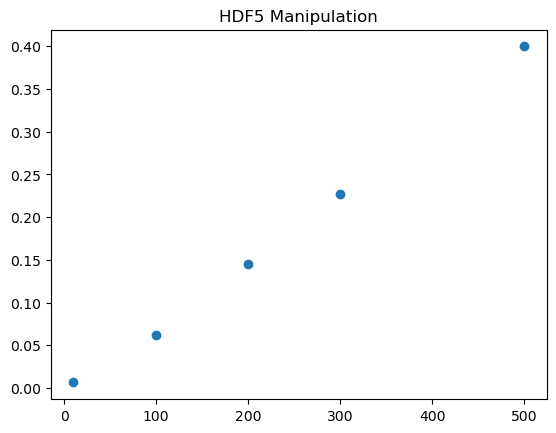

In [21]:
plt.title("HDF5 Manipulation")
plt.scatter(N,t_manipulate_h5)

# Arrow 

In [44]:
from tqdm import tqdm
t_load_arrow = []
t_manipulate_arrow = []
iterations = 100
selected_label = 6

for item in N:
    tmp_load = []
    tmp_manipulate = []
    for j in tqdm(range(iterations)):
        st_time = time.time()
        ### LOADING ###
        table = pq.read_table(f'f2_{item}.parquet')
        ### ------- ###
        en_time = time.time()
        tmp_load.append(en_time - st_time)
          
        start_time = time.time()
        ### MANIPULATION ###
        manipulated_images = []
        for k in range(item):
            if any( x == selected_label for x in table.column("image_feature").chunk(0)[k][0]["class_feature"].values.field("label").to_pylist()):  ## Indice di immagine deve variare nel framework
                obj = table.column("image_feature").chunk(0)[k][0]["image"]
                image_numpy = np.frombuffer(obj.as_buffer(), dtype=np.float64).reshape(3, 125, 125)
                new_obj = np.transpose(image_numpy)   
                new_obj = np.square(new_obj)
                new_obj = np.exp(new_obj)
                new_obj = np.transpose(new_obj)
                manipulated_images.append(new_obj)
        ### ----------- ###
        end_time = time.time()
        tmp_manipulate.append(end_time-start_time)
            
    t_load_arrow.append(sum(tmp_load) / len(tmp_load))
    t_manipulate_arrow.append(sum(tmp_manipulate) / len(tmp_manipulate))

np.save("t_load_arrow_f2",t_load_arrow)
np.save("t_manipulate_arrow_f2",t_manipulate_arrow)

100%|██████████| 100/100 [01:33<00:00,  1.06it/s]


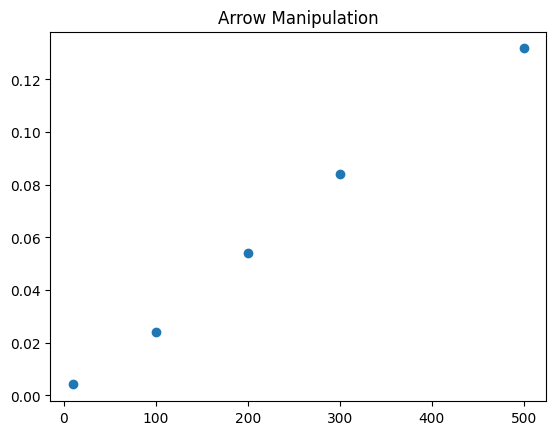

In [45]:
plt.title("Arrow Manipulation")
plt.scatter(N,t_manipulate_arrow)

NameError: name 't_manipulate_h5' is not defined

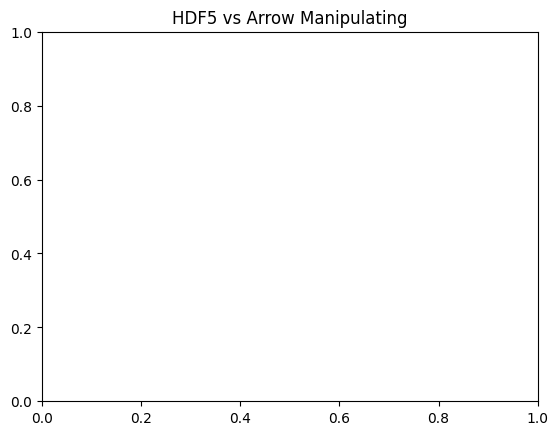

In [46]:
plt.title("HDF5 vs Arrow Manipulating")
plt.plot(N, t_manipulate_h5, label="hdf5", color='blue')

# Create the second plot
plt.plot(N, t_manipulate_arrow, label="arrow", color='red')

# Add a legend
plt.legend()

# Add titles and labels
plt.xlabel("N (number of samples)")
plt.ylabel("t (seconds)")

# Show the plot
plt.show()